In [118]:
from spineq.optimise import get_optimisation_inputs
from spineq.utils import coverage_matrix
from spineq.plotting import plot_optimisation_result
from spineq.data_fetcher import get_oa_shapes, get_oa_centroids

import pygmo as pg

import numpy as np
import pandas as pd

from time import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_sensors = 20
theta = 500

population_weight = 1
workplace_weight = 1
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 0},
    "pop_children": {"min": 0, "max": 16, "weight": 0},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1},
}

## Get Input Data

In [3]:
data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=False,
)

objs = list(data["oa_weight"].keys())
objs

['pop_elderly', 'workplace']

## PyGMO Multi-Objective Problem

- One decision variable for each sen?sor to be placed, variable value is index of location
- One objective per separate weight group defined above, e.g. total population, children, elderly and workplace.

In [4]:
# PyGMO User Defined Problem
class optimise_oa:
    def __init__(self, oa_x, oa_y, oa_weight,
                 n_sensors, theta):
        
        self.n_sensors = n_sensors
        self.n_locations = len(oa_x)
        self.n_obj = len(oa_weight)
        self.oa_weight = oa_weight
        self.coverage = coverage_matrix(oa_x, oa_y, theta=theta)
          
    def fitness(self, sensors_idx):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # Construct sensors vector from indices
        sensors = np.zeros(self.n_locations)
        sensors[sensors_idx.astype(int)] = 1
        
        fitness_sensors = []
        for w in self.oa_weight.values():
            # only keep coverages due to output areas where a sensor is present
            mask_cov = np.multiply(self.coverage, sensors[np.newaxis, :])

            # coverage at each output area = coverage due to nearest sensor
            max_mask_cov = np.max(mask_cov, axis=1)

            # weighted coverage of solution = the objective
            fitness_sensors.append(
                -(w * max_mask_cov).sum() / w.sum()
            )
        
        return fitness_sensors
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.n_sensors, [self.n_locations-1]*self.n_sensors)
    
    # Return number of objectives
    def get_nobj(self):
        return self.n_obj
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 0
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.n_sensors
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    


In [5]:
# Build problem
oa_opt = optimise_oa(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(oa_opt)

print(prob)

Problem name: <class '__main__.optimise_oa'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			2
	Number of objectives:			2
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



## NSGA2

In [6]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.nsga2(gen=1000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: NSGA-II: [stochastic]
	C++ class name: pagmo::nsga2

	Thread safety: basic

Extra info:
	Generations: 1000
	Crossover probability: 0.95
	Distribution index for crossover: 10
	Mutation probability: 0.01
	Distribution index for mutation: 50
	Seed: 2039513021
	Verbosity: 1


In [7]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())

# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

f evals 100100
g evals 0


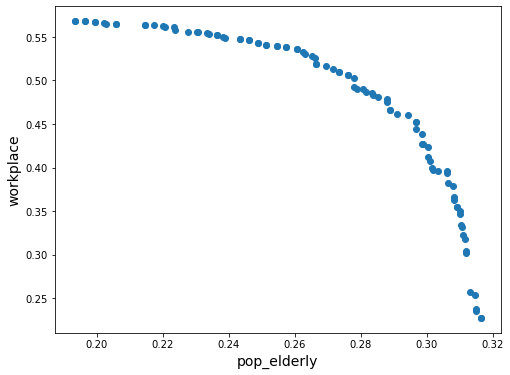

In [8]:
# plot fitness values for first two objectives
plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[1], fontsize=14)
plt.savefig("work_elderly_opt.png", dpi=200)

In [9]:
# sort fits in order of first objective value
x = -fits.copy()
x[x[:, 0].argsort()]

array([[0.19339012, 0.56787449],
       [0.19339012, 0.56787449],
       [0.1964518 , 0.56777377],
       [0.1964518 , 0.56777377],
       [0.19941497, 0.56709706],
       [0.19941497, 0.56709706],
       [0.20232923, 0.5653945 ],
       [0.20269628, 0.56520084],
       [0.20573414, 0.56509461],
       [0.20573414, 0.56509461],
       [0.21471401, 0.56403211],
       [0.21471401, 0.56403211],
       [0.21751123, 0.56376807],
       [0.22017907, 0.56285019],
       [0.22085007, 0.56188734],
       [0.22351791, 0.56096946],
       [0.22371319, 0.55768993],
       [0.2276191 , 0.55619377],
       [0.23041632, 0.55592973],
       [0.23065659, 0.55563959],
       [0.23332444, 0.55472171],
       [0.23392501, 0.5536285 ],
       [0.23659285, 0.55271062],
       [0.23659285, 0.55271062],
       [0.23831115, 0.54938186],
       [0.23875497, 0.54830297],
       [0.24356168, 0.54780125],
       [0.24356168, 0.54780125],
       [0.24622952, 0.54688337],
       [0.24622952, 0.54688337],
       [0.

## Other Algorithms

In [10]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.moead(gen=100))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=105)


Algorithm name: MOEAD: MOEA/D - DE [stochastic]
	C++ class name: pagmo::moead

	Thread safety: basic

Extra info:
	Generations: 100
	Weight generation: grid
	Decomposition method: tchebycheff
	Neighbourhood size: 20
	Parameter CR: 1
	Parameter F: 0.5
	Distribution index: 20
	Chance for diversity preservation: 0.9
	Seed: 391472875
	Verbosity: 1


f evals 10605
g evals 0


Text(0, 0.5, 'workplace')

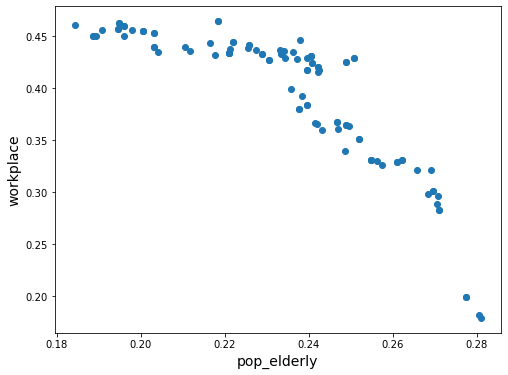

In [11]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())

# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

# plot fitness values for first two objectives
plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[1], fontsize=14)

## 3 Objectives?

In [12]:
population_weight = 1
workplace_weight = 1
pop_age_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 0},
    "pop_children": {"min": 0, "max": 16, "weight": 1},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1},
}

data = get_optimisation_inputs(
    population_weight=population_weight,
    workplace_weight=workplace_weight,
    pop_age_groups=pop_age_groups,
    combine=False,
)


objs = list(data["oa_weight"].keys())
objs

['pop_children', 'pop_elderly', 'workplace']

In [13]:
# Build problem
oa_opt = optimise_oa(
    data["oa_x"],
    data["oa_y"],
    data["oa_weight"],
    n_sensors,
    theta,
)

prob = pg.problem(oa_opt)

print(prob)

Problem name: <class '__main__.optimise_oa'>
	C++ class name: pybind11::object

	Global dimension:			20
	Integer dimension:			20
	Fitness dimension:			3
	Number of objectives:			3
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [951, 951, 951, 951, 951, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 60
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [14]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.nsga2(gen=1000))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: NSGA-II: [stochastic]
	C++ class name: pagmo::nsga2

	Thread safety: basic

Extra info:
	Generations: 1000
	Crossover probability: 0.95
	Distribution index for crossover: 10
	Mutation probability: 0.01
	Distribution index for mutation: 50
	Seed: 4058792273
	Verbosity: 1


In [15]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())

# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract non-dominated fronts
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

print("Best fitness values for single objectives:")
for i in range(len(objs)):
    print(objs[i], fits[:,i].min())

f evals 100100
g evals 0
Best fitness values for single objectives:
pop_children -0.33563007012916063
pop_elderly -0.31004087889476256
workplace -0.5701099685420806


Text(0, 0.5, 'workplace')

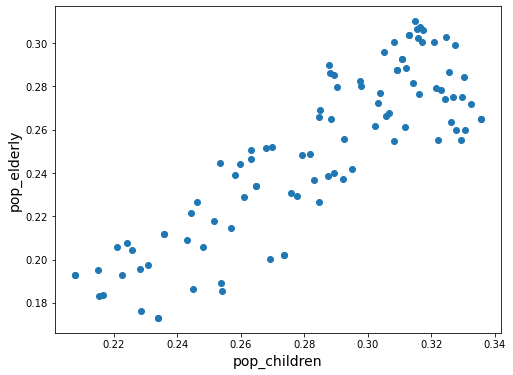

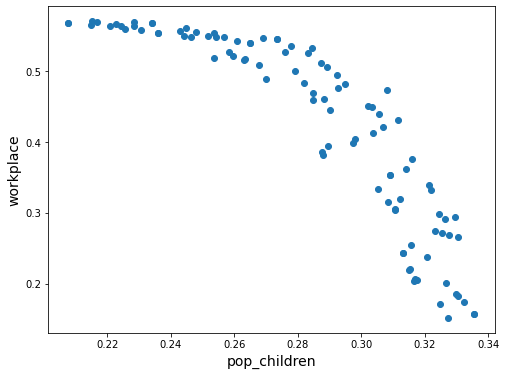

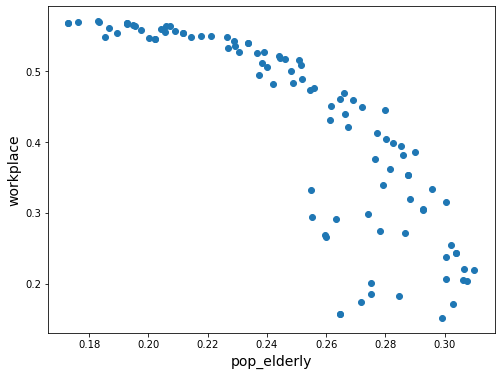

In [16]:
# plot fitness values for two objectives
objs = list(data["oa_weight"].keys())

plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[1], fontsize=14)

plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,2], 'o')
plt.xlabel(objs[0], fontsize=14)
plt.ylabel(objs[2], fontsize=14)

plt.figure(figsize=(8,6))
plt.plot(-fits[:,1], -fits[:,2], 'o')
plt.xlabel(objs[1], fontsize=14)
plt.ylabel(objs[2], fontsize=14)

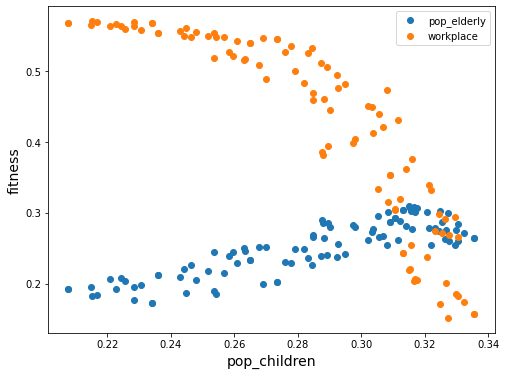

In [17]:
plt.figure(figsize=(8,6))
plt.plot(-fits[:,0], -fits[:,1], 'o', label=objs[1])
plt.plot(-fits[:,0], -fits[:,2], 'o', label=objs[2])
plt.xlabel(objs[0], fontsize=14)
plt.ylabel("fitness", fontsize=14)
plt.legend()

In [18]:
# sort fits in order of first objective value
x = -fits.copy()
x[x[:, 0].argsort()]

array([[0.20778104, 0.19265594, 0.56743187],
       [0.20778104, 0.19265594, 0.56743187],
       [0.21497477, 0.19494372, 0.56437418],
       [0.21532548, 0.1831294 , 0.57010997],
       [0.21665965, 0.18341231, 0.56862884],
       [0.22093752, 0.20598649, 0.56399799],
       [0.22259308, 0.19274934, 0.56699821],
       [0.22425701, 0.20740431, 0.56295342],
       [0.22564612, 0.20418971, 0.55915325],
       [0.22826366, 0.19545826, 0.56312954],
       [0.22854049, 0.17631178, 0.5689194 ],
       [0.23066061, 0.19744383, 0.55719149],
       [0.23398993, 0.17305286, 0.56772819],
       [0.23398993, 0.17305286, 0.56772819],
       [0.23594455, 0.21158875, 0.55390153],
       [0.23594455, 0.21158875, 0.55390153],
       [0.24290812, 0.20913025, 0.55605832],
       [0.24427181, 0.22131353, 0.54952382],
       [0.24487294, 0.18657554, 0.56000073],
       [0.24629364, 0.22661485, 0.54866598],
       [0.2480879 , 0.20564359, 0.55483297],
       [0.25158803, 0.21782818, 0.54939903],
       [0.

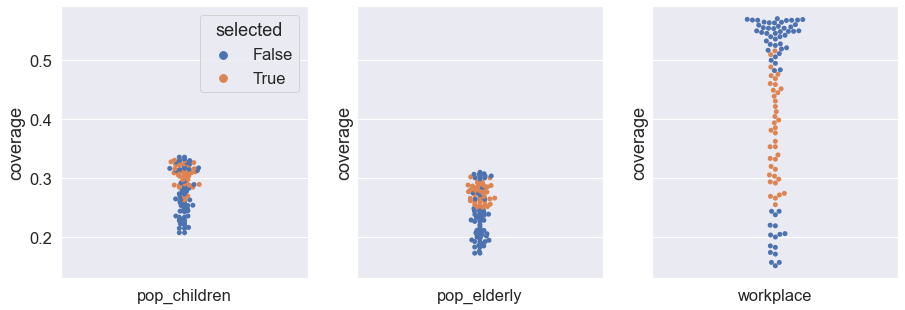

In [151]:
df = pd.DataFrame(x, columns=objs)
df["selected"] = (df["workplace"] > 0.25) & (df["pop_children"] > 0.25) & (df["pop_elderly"] > 0.25)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.set(font_scale=1.5)
for i, col in enumerate(objs):
    sns.swarmplot(
        x=[col]*len(df), y=df[col], hue=df["selected"], ax=ax[i]
    )
    ax[i].set_ylabel("coverage")
    if i > 0:
        ax[i].get_legend().remove()